In [2]:
import pandas as pd
file_path = 'data/sp500/SP500.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

### Compute average and standard deviation of all numerical values for each ticker

In [3]:
grouped_stats = df.groupby('Ticker').agg(['mean', 'std'])
grouped_stats.drop(columns=('Date',), axis=1, inplace=True, errors='ignore')  # Droppo la data (colonna non numerica)

grouped_stats.head()

Low                  Open                   Volume  \
             mean        std       mean        std          mean   
Ticker                                                             
A       44.378031  35.131543  44.956648  35.525085  3.455684e+06   
AAL     24.942728  15.708710  25.441034  15.905032  1.437739e+07   
AAP     90.334993  60.561938  91.457988  61.302219  1.172943e+06   
AAPL    16.141083  34.495971  16.323966  34.904787  3.279583e+08   
ABBV    81.142782  29.850621  82.029305  30.133433  7.769110e+06   

                           High                 Close             \
                 std       mean        std       mean        std   
Ticker                                                             
A       2.433841e+06  45.534710  35.886952  44.966740  35.509658   
AAL     2.196859e+07  25.909781  16.091607  25.414120  15.904093   
AAP     9.537524e+05  92.530779  61.976656  91.452945  61.282001   
AAPL    3.379551e+08  16.509548  35.327844  16.332137  34.928463   
ABBV    5.227982e+06  82.931006  30.467865  82.075123  30.188153   

       Adjusted Close             
                 mean        std  
Ticker                            
A           42.495033  35.888440  
AAL         24.446001  15.236071  
AAP         86.724267  59.505816  
AAPL        15.660945  34.596768  
ABBV        69.383165  33.760089

### Outliers Research

In [4]:
numerical_columns = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
outlier_log = []

for col in numerical_columns:
    for ticker in df['Ticker'].unique():
        mean = grouped_stats.loc[ticker, (col, 'mean')]
        std = grouped_stats.loc[ticker, (col, 'std')]

        # Outliers condition defined with z-score and coefficient = 5 
        outlier_condition = abs(df.loc[df['Ticker'] == ticker, col] - mean) > (5 * std)

        outliers = df.loc[df['Ticker'] == ticker, col][outlier_condition]
        for index, value in outliers.items():
            outlier_log.append({
                'Index': index,
                'Ticker': ticker,
                'Column': col,
                'OriginalValue': value
            })

outlier_log_df = pd.DataFrame(outlier_log)

In [5]:
outlier_log_df

,Index,Ticker,Column,OriginalValue
0,136470,AKAM,Low,268.000000
1,136471,AKAM,Low,282.937500
2,136472,AKAM,Low,290.250000
3,136473,AKAM,Low,287.687500
4,136474,AKAM,Low,274.250000
...,...,...,...,...
15436,3187039,WST,Adjusted Close,444.844208
15437,3221908,XLEFF,Adjusted Close,0.802900
15438,3221909,XLEFF,Adjusted Close,0.802900
15439,3221910,XLEFF,Adjusted Close,0.802900


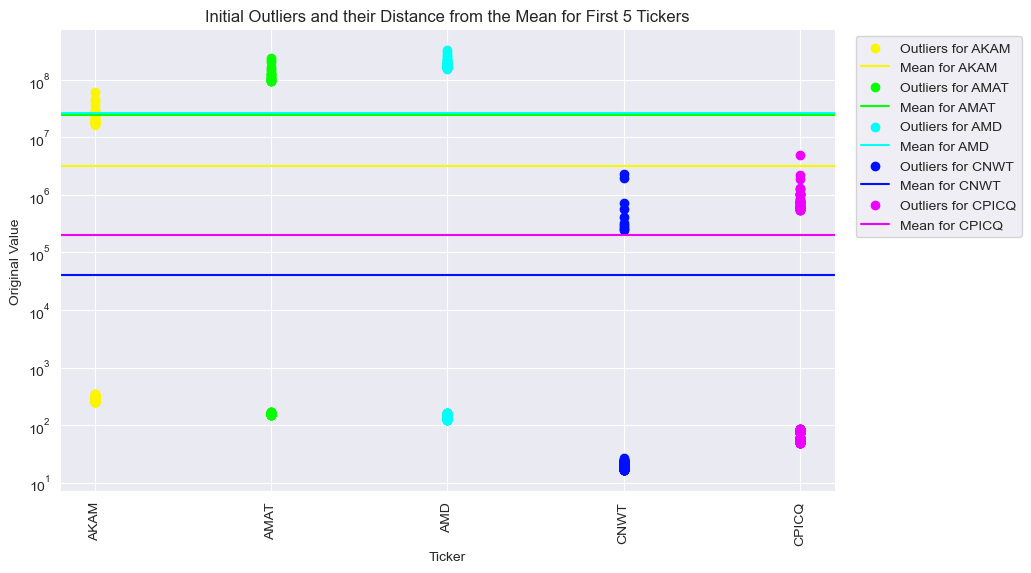

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 unique tickers from the original dataframe
first_5_tickers = outlier_log_df['Ticker'].unique()[:5]

# Filter the original DataFrame and outliers_log_df for these tickers
df_filtered = outlier_log_df[outlier_log_df['Ticker'].isin(first_5_tickers)]
outliers_log_df_filtered = outlier_log_df[outlier_log_df['Ticker'].isin(first_5_tickers)]

# Calculate the mean for each of the first 5 Ticker groups
group_means = df_filtered.groupby('Ticker')['OriginalValue'].mean()

# Define colors for the first 5 tickers
colors = sns.color_palette('hsv', n_colors=5)

# Plot
plt.figure(figsize=(10, 6))

# Plot each outlier from outliers_log_df_filtered and its corresponding mean line
for i, ticker in enumerate(first_5_tickers):
    ticker_outliers = outliers_log_df_filtered[outliers_log_df_filtered['Ticker'] == ticker]
    mean_value = group_means[ticker]
    color = colors[i]

    plt.scatter(ticker_outliers['Ticker'], ticker_outliers['OriginalValue'], color=color, label=f'Outliers for {ticker}')
    plt.axhline(y=mean_value, color=color, linestyle='-', label=f'Mean for {ticker}')

plt.xlabel('Ticker')
plt.ylabel('Original Value')
plt.title('Initial Outliers and their Distance from the Mean for First 5 Tickers')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

### Outliers Research in batches of 10 years 

In [31]:
from typing import List

def remove_outliers_in_batches(df: pd.DataFrame, columns: List[str], coefficient: int) -> pd.DataFrame:
    # Copy of df
    new_df = df.copy()

    # Add columns to the new dataframe to flag outliers
    for col in columns:
        new_df[col + '_Outlier'] = False

    # Process each ticker separately
    for ticker in new_df['Ticker'].unique():
        ticker_data = new_df[new_df['Ticker'] == ticker]
        ticker_data = ticker_data.sort_values(by='Date')

        # Get the range of years
        start_year = ticker_data['Date'].dt.year.min()
        end_year = ticker_data['Date'].dt.year.max()

        # Process in batches of up to 10 years
        for start in range(start_year, end_year, 10):
            end = min(start + 10, end_year + 1)
            batch = ticker_data[(ticker_data['Date'].dt.year >= start) & (ticker_data['Date'].dt.year < end)]

            # Compute the mean and std dev for the batch
            stats = batch[columns].agg(['mean', 'std'])

            # Find and flag outliers in the batch
            for col in columns:
                mean = stats[col]['mean']
                std = stats[col]['std']
                outlier_condition = abs(batch[col] - mean) > (coefficient * std)
                batch_indices = batch[outlier_condition].index
                new_df.loc[batch_indices, col + '_Outlier'] = True

    return new_df

In [32]:
coefficient = 5
outlier_detected_df = remove_outliers_in_batches(df, numerical_columns, coefficient)

outlier_details = []
for index, row in outlier_detected_df.iterrows():
    for col in numerical_columns: 
        if row[col + '_Outlier']:
            outlier_details.append({
                'Ticker': row['Ticker'],
                'Index': index,
                'OutlierColumn': col,
                'OutlierValue': row[col]
            })

outliers_summary_df = pd.DataFrame(outlier_details)

# The summary contains only "True" outliers from outliers_detected_df
outliers_summary_df

,Ticker,Index,OutlierColumn,OutlierValue
0,A,0,Volume,6.254638e+07
1,A,73,High,1.158798e+02
2,A,73,Close,1.137339e+02
3,A,73,Adjusted Close,9.731437e+01
4,A,74,Low,9.370529e+01
...,...,...,...,...
15881,ZTS,3263619,Volume,1.760100e+07
15882,ZTS,3263774,Volume,2.913720e+07
15883,ZTS,3263964,Volume,2.022850e+07
15884,ZTS,3263965,Volume,2.141490e+07


In [40]:
# I want to check outliers within those previous ones comparing only between them to check for very "wrong" values
rechecked_outliers = []

# Group by 'Ticker' and 'OutlierColumn' to re-check the outliers within each subset
grouped = outliers_summary_df.groupby(['Ticker', 'OutlierColumn'])

for (ticker, col), group in grouped:
    # Calculate mean and std for the outlier values in this group
    mean = group['OutlierValue'].mean()
    std = group['OutlierValue'].std()

    # Use a coefficient of 3 to determine if any are still outliers
    for index, row in group.iterrows():
        if index > 0:
            if abs(row['OutlierValue'] - mean) > 3 * std:
                rechecked_outliers.append(row)

# Convert the list to a DataFrame
rechecked_outliers_df = pd.DataFrame(rechecked_outliers)

# Now `rechecked_outliers_df` contains the re-checked outliers, which are the very offset values
rechecked_outliers_df

,Ticker,Index,OutlierColumn,OutlierValue
130,AAP,14091,Volume,1.974950e+07
168,AAPL,20437,Volume,7.421641e+09
269,ABMD,43273,Volume,1.094450e+07
336,ACN,57699,Volume,8.965590e+07
433,ADM,78152,Volume,5.241480e+07
...,...,...,...,...
15398,WRB,3162720,Volume,5.435891e+07
15489,WST,3186631,Volume,1.649570e+07
15551,WY,3201742,Volume,5.759470e+07
15595,XEL,3212816,Volume,2.484980e+07


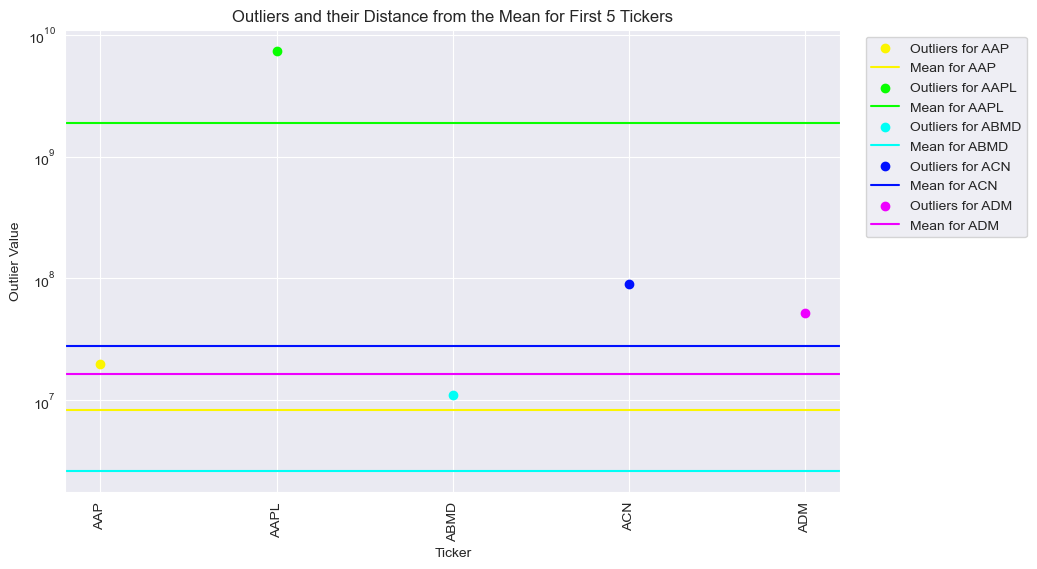

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 unique tickers from the original dataframe
first_5_tickers = rechecked_outliers_df['Ticker'].unique()[:5]

# Filter the original DataFrame and outliers_log_df for these tickers
df_filtered = rechecked_outliers_df[rechecked_outliers_df['Ticker'].isin(first_5_tickers)]
outliers_log_df_filtered = rechecked_outliers_df[rechecked_outliers_df['Ticker'].isin(first_5_tickers)]

# Calculate the mean for each of the first 5 Ticker groups
group_means = outliers_summary_df.groupby('Ticker')['OutlierValue'].mean()

# Define colors for the first 5 tickers
colors = sns.color_palette('hsv', n_colors=5)

# Plot
plt.figure(figsize=(10, 6))

# Plot each outlier from outliers_log_df_filtered and its corresponding mean line
for i, ticker in enumerate(first_5_tickers):
    ticker_outliers = outliers_log_df_filtered[outliers_log_df_filtered['Ticker'] == ticker]
    mean_value = group_means[ticker]
    color = colors[i]

    plt.scatter(ticker_outliers['Ticker'], ticker_outliers['OutlierValue'], color=color, label=f'Outliers for {ticker}')
    plt.axhline(y=mean_value, color=color, linestyle='-', label=f'Mean for {ticker}')

plt.xlabel('Ticker')
plt.ylabel('Outlier Value')
plt.title('Outliers and their Distance from the Mean for First 5 Tickers')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
plt.yscale('log')
plt.xticks(rotation=90)
plt.show()